<a href="https://colab.research.google.com/github/juliosdutra/ModelagemPPEQ1019/blob/main/meat_composition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Exemplo de aplicação: análise da composição de carnes

O conjunto de dados está relacionado com análises de composição de amostras de carne. O objetivo é fazer uso registros de um "Tecator Infratec Food and Feed Analyzer", na faixa de comprimento de onda 850 - 1050 nm pelo princípio de transmissão de infravermelho próximo, para predição do conteúdo de água, gordura e proteína da carne. Então, basicamente, a ideia da modelagem é evitar o trabalho de medição demorado e depender apenas de colocar a amostra de carne no scanner e obter o conteúdo estimado de gordura, água e proteína.

Neste conjunto, há 215 amostras compostas de:
* 100 canais de espectro de absorbância (*features*); e
* 3 variáveis dependentes (*targets*): as porcentagens de água, gordura e proteína.

O objetivo da Regressão Linear é modelar a relação de dependência entre as variáveis dependentes (*targets*) e múltiplas variáveis independentes (*features*).

Para mais detalhes, veja uma descrição disponível em:
https://search.r-project.org/CRAN/refmans/modeldata/html/meats.html

# CÓDIGO COMPLETO

📌 O que esse código faz?

1️⃣ Baixa os dados do GitHub

2️⃣ Pré-processa os espectros (SNV → Z-score → Savitzky-Golay)

3️⃣ Divide os dados em treino e teste (80% treino, 20% teste)

4️⃣ Treina um modelo PLSR (com 10 componentes)

5️⃣ Faz previsões e avalia o modelo (RMSE e R²)

6️⃣ Gera gráficos predição vs valor real para cada variável alvo


💡 Dicas para melhorar:

🔹 Ajuste o número de componentes PLS (n_components) para otimizar o desempenho

🔹 Teste diferentes parâmetros de suavização (Savitzky-Golay)

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter

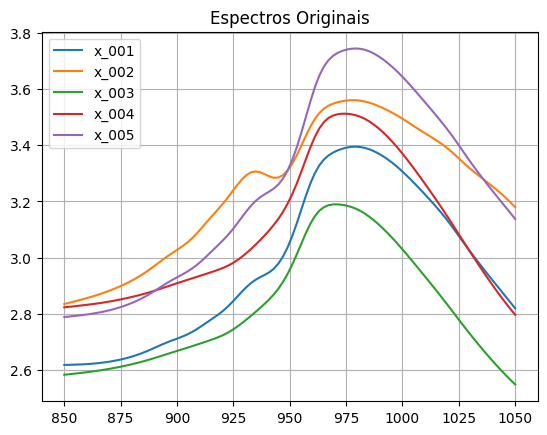

In [209]:
# 🔹 1️⃣ Importar os dados
url = "https://raw.githubusercontent.com/juliosdutra/ModelagemPPEQ1019/main/meats.csv"
df = pd.read_csv(url)

# Separar as features (espectros) e os targets (composição química)
X = df.iloc[:, :-3].values  # Espectros (100 colunas)
y = df.iloc[:, -3:].values  # Teores de água, gordura e proteína

# Visualização
n,m = X.shape
w = np.linspace(850,1050,m)

for k in range(5): # Plot das 5 primeiras amostras
    plt.plot(w, X[k,:], label = df.columns[k])
plt.title("Espectros Originais")
plt.legend()
plt.grid();

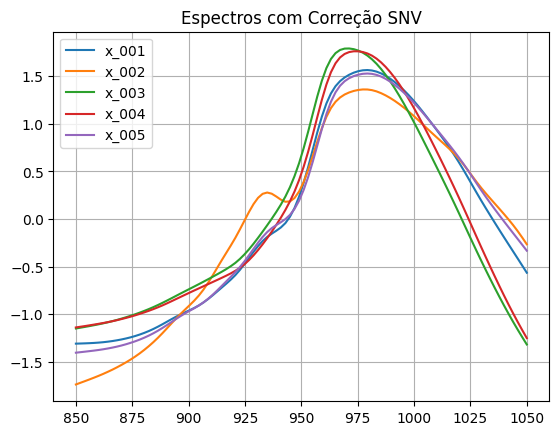

In [202]:
# 🔹 2️⃣ Pré-processamento

## SNV (Standard Normal Variate)
def snv(input_data):
    return (input_data - np.mean(input_data, axis=1, keepdims=True)) / np.std(input_data, axis=1, keepdims=True)

X_snv = snv(X)

for k in range(5): # Plot das 5 primeiras amostras
    plt.plot(w, X_snv[k,:], label = df.columns[k])
plt.title("Espectros com Correção SNV")
plt.legend()
plt.grid();

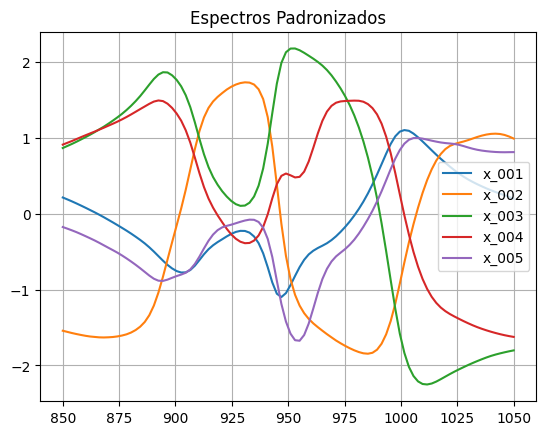

In [204]:
## Padronização (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_snv)

for k in range(5): # Plot das 5 primeiras amostras
    plt.plot(w, X_scaled[k,:], label = df.columns[k])
plt.title("Espectros Padronizados")
plt.legend()
plt.grid();

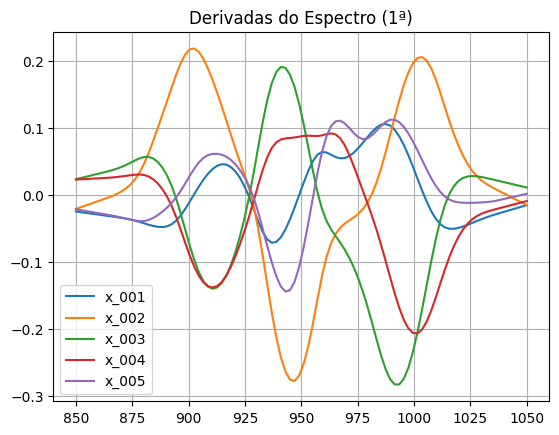

In [205]:
## Suavização e derivadas (Savitzky-Golay)
# 1ª Derivada (Savitzky-Golay)
X_smooth = savgol_filter(X_scaled, window_length=15, polyorder=2, deriv=1, axis=1)

for k in range(5): # Plot das 5 primeiras amostras
    plt.plot(w, X_smooth[k,:], label = df.columns[k])
plt.title("Derivadas do Espectro (1ª)")
plt.legend()
plt.grid();

In [206]:
# 🔹 3️⃣ Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X_smooth, y, test_size=0.2, random_state=42)

# 🔹 4️⃣ Treinamento do modelo PLSR
pls = PLSRegression(n_components=17)  # Ajuste o número de componentes
pls.fit(X_train, y_train)

# 🔹 5️⃣ Predição e Validação
y_pred = pls.predict(X_test)

In [207]:
## Cálculo das métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 1.6276
R²: 0.9706


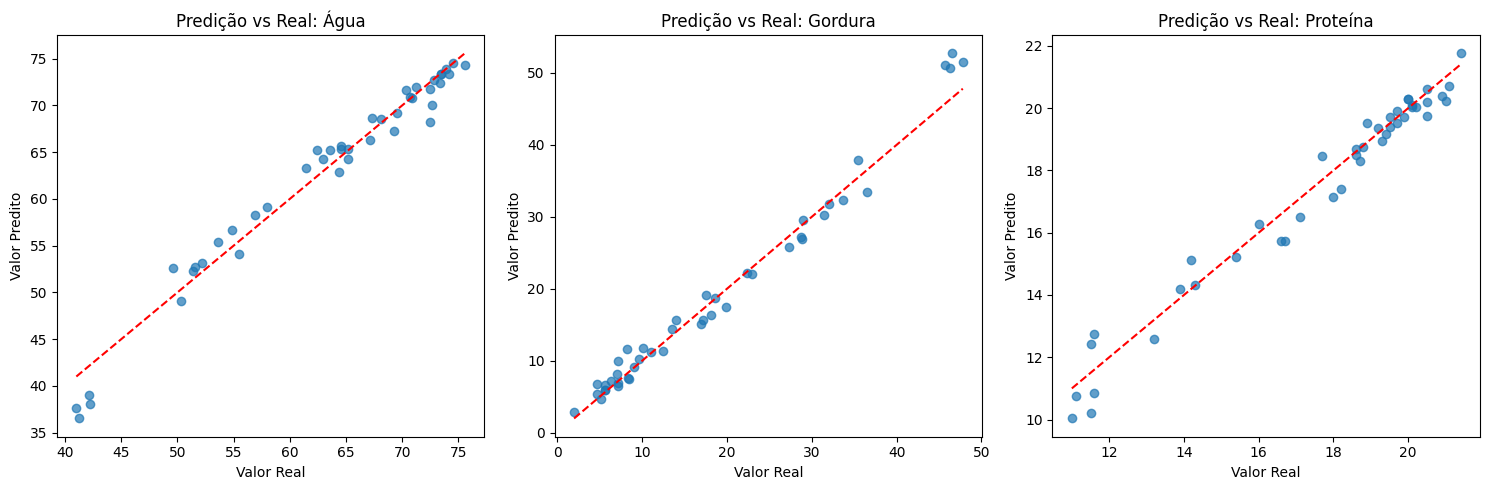

In [208]:
# 🔹 6️⃣ Visualização dos Resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
targets = ["Água", "Gordura", "Proteína"]

for i in range(3):
    axes[i].scatter(y_test[:, i], y_pred[:, i], alpha=0.7)
    axes[i].plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r--')
    axes[i].set_title(f"Predição vs Real: {targets[i]}")
    axes[i].set_xlabel("Valor Real")
    axes[i].set_ylabel("Valor Predito")

plt.tight_layout()
plt.show()